## Background
Automatic region proposal generators like selective search should inspect the image and attempt to find regions likely to contain an object. It will then pass these "candidate proposals" to a downstream classifier.

Selective search works by over-segmenting an image using a superpixel algorithm. From there, it seeks to merge together the superpixels to find regions of an image that could contain an object.

Selective search merges superpixels in a hierarchical fashion based on 5 key similarity measures:

* Color: computing a 25-bin histogram for each channel of an image, concating them together and obtaining a final descriptor that is 25x3=75d. Color similarity of any two regions is measured by the histogram intersection distance.

* Texture: extracts Gaussian derivatives at 8 orientations per channel (assuming a 3-channel image). These orientations are used to compute a 10-bin histogram per channel, generating a final texture descriptor that is 8x10x3=240d. Histogram intersection used to compute texture similarity between 2 regions.

* Size: size similarity metric used here prefers that smaller regions be grouped earlier rather than later. Avoids the problem seen in Hierarchical Agglomerative Clustering which by nature is prone to clusters reaching a critical mass and then combining everything they touch.

* Shape: Two regions are considered "compatible" if they "fit" into each other, i.e. leaving minimal gaps. Two shapes that are not touching should not be merged.

* Meta-similarity measure: a final meta-similarity acts as a linear combination of the above similarities.

*Histogram intersection: https://mpatacchiola.github.io/blog/2016/11/12/the-simplest-classifier-histogram-intersection.html

# Object detection #2
sources: https://pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

Object detection with selective search. Automatic region proposals such as selective search paved the way for RCNN.

Research with selective search has allowed the creation of state-of-the-art Region Proposal Network (RPN) components that are even more accurate and efficient thatn selective search (used in faster RCNNs).

However for this exercise we will only be delving into the selective search component which is a pluggable replacement for the previous image pyramid and sliding window method.

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import cv2

## Load selective search with cv2

In [2]:
img = cv2.imread('lawn_mower.png')
img = np.flip(img, axis=-1)
# init cv2 selective search implementation and set input img
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
# use fast quality
ss.switchToSelectiveSearchFast()

## Run selective search

In [3]:
start = time.time()
rects = ss.process()
end = time.time()
print('Selective search took {:.4f}s'.format(end - start))
print('{} total region proposals'.format(len(rects)))

Selective search took 2.0955s
1684 total region proposals


Visualize our region proposals.

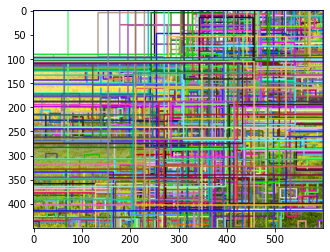

In [9]:
output = img.copy()
for (x, y, w, h) in rects:
    # draw region proposal bbox
    color = [random.randint(0, 255) for j in range(3)]
    cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
plt.imshow(output)   

Selective search is fast and usually accomplishes it's task within mere seconds. The bboxes (ROIs) are then sent downstream to a classifier (SVM, CNN etc) for classification.

In most cases "fast" mode is sufficient, but you may choose to use "quality" mode if:

* real-time detection is not a concern

* using selective search to generate training data (thus we want more regions, both positive and negative)